# Mobile Games

## Условия задач проекта

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1) В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

2) Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3) Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Импорт библиотек

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from datetime import date,timedelta, datetime

## Задание №1

### Условия задачи

Напишите функцию для подсчета Retention.

### Разведка данных

Перед созданием функции для расчета Retention необходимо разведать данные, чтобы понять как лучше написать функцию.

In [2]:
# Считываем csv файл с информацией о дате регистрации пользователей и сохраняем в переменной 'problem_reg_df'
problem_reg_df = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')

In [3]:
# Изучаем датафрейм 'problem_reg_df'
#(количество серий и их наименования, тип данных в сериях, наличие пустых значений в строках)
problem_reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [4]:
# Смотрим общее количество строк в 'problem_reg_df'
print(f'Общее количество строк в problem_reg_df: {problem_reg_df.shape[0]}')

# Смотрим уникальное количество id игроков в 'problem_reg_df'(не всегда данные бывают адекватными)
print(f'Уникальное количество id игроков в problem_reg_df: {problem_reg_df.uid.nunique()}')

# Смотрим количество уникальных значений в дате регистрации в 'problem_reg_df'
print(f'Уникальное количество дат регистрации в problem_reg_df: {problem_reg_df.reg_ts.nunique()}')

Общее количество строк в problem_reg_df: 1000000
Уникальное количество id игроков в problem_reg_df: 1000000
Уникальное количество дат регистрации в problem_reg_df: 1000000


In [5]:
# Проевряем датафрейм 'problem_reg_df' на наличие дубликатов
print(f'Количество дубликатов в problem_reg_df: {problem_reg_df.duplicated().sum()}')

Количество дубликатов в problem_reg_df: 0


In [6]:
# Считываем csv файл с информацие о дате регистрации пользователей и сохраняем в переменной 'problem_auth_df'
problem_auth_df = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [7]:
# Изучаем датафрейм 'problem_auth_df'
#(количество серий и их наименования, тип данных в сериях)
problem_auth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [8]:
#Проверяем датафрейм на наличие пустых значений в строках
problem_auth_df.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [9]:
# Смотрим общее количество строк в 'problem_auth_df'
print(f'Общее количество строк в problem_auth_df: {problem_auth_df.shape[0]}')

# Смотрим уникальное количество id игроков в 'problem_auth_df'(не всегда данные бывают адекватными)
print(f'Уникальное количество id игроков в problem_auth_df: {problem_auth_df.uid.nunique()}')

# Смотрим количество уникальных значений в дате авторизации в 'problem_auth_df'
print(f'Уникальное количество дат регистрации в problem_auth_df: {problem_auth_df.auth_ts.nunique()}')


Общее количество строк в problem_auth_df: 9601013
Уникальное количество id игроков в problem_auth_df: 1000000
Уникальное количество дат регистрации в problem_auth_df: 9180915


In [10]:
# Проевряем датафрейм 'problem_auth_df' на наличие дубликатов
print(f'Количество дубликатов в problem_auth_df: {problem_auth_df.duplicated().sum()}')

Количество дубликатов в problem_auth_df: 0


In [11]:
# Проверяем есть ли id игроков, которые встречаются только в одном датафрейме (в теории могут быть ошибки)
uid_unique = set(problem_reg_df.uid.values) - set(problem_auth_df.uid.values)
print(f'Количество id игроков, которые присутствуют лишь в одном датафрейме: {len(uid_unique)}')

# Удаляем ненужную переменную
del uid_unique

Количество id игроков, которые присутствуют лишь в одном датафрейме: 0


In [12]:
# Необходимо проверить нет ли случаев, когда у игроков дата регистрации позже, чем авторизация (возможные ошибки)
# Для этого обьединим датафреймы в problem_df
problem_df = pd.merge(problem_reg_df,
                      problem_auth_df,
                      on='uid',
                      how='inner')

# Смотрим количество строк в problem_df, чтобы убедиться в правильности объединения датафреймов
print(f'Количество строк в problem_df: {problem_df.shape[0]}')

Количество строк в problem_df: 9601013


In [13]:
# Приводим дату регистрации к формату 'YYYY-MM-DD'
problem_df['reg_ts'] = pd.to_datetime(problem_df['reg_ts'], unit='s').dt.date

# Приводим дату авторизации к формату 'YYYY-MM-DD'
problem_df['auth_ts'] = pd.to_datetime(problem_df['auth_ts'], unit='s').dt.date

# Сравниваем даты и записываем в серию 'dif_datetime'
problem_df['dif_datetime'] = problem_df['reg_ts'] <= problem_df['auth_ts']

# Выводим получившиеся булевые значения. Наличие False будет означать об ошибках
problem_df.dif_datetime.value_counts()

True    9601013
Name: dif_datetime, dtype: int64

In [14]:
# Удаляем ненужный датафрейм
del problem_df

Выводы:
1) Каждый датафрейм имеет по 2 серии (id игрока - общая, дата регистрации/дата авторизации - каждая только в одном из датафреймов);
2) Количество строк для 'problem_reg_df' и 'problem_auth_df': 1000000 и 9601013 (соответственно);
3) Дата регистрации и дата авторизации хранятся в формате Unix-времени;
4) Колличество уникальных id игрокв везде 1000000;
5) Уникальное количество дат регистрации 1000000 (нормально, так дата содержит часы, минуты и т.д.), уникальное количество дат авторизации (9180915);
6) Дублирующихся строк нет ни в одном датафрейме;
7) Нет ни одного игрока, который бы присутствовал лишь в одном датафрейме;
8) Нет ни одной даты регистрации у игроков, которая бы возникала позже даты авторизации (ошибок/нюансов нет)

### Создание функцию для расчета Retention

Теперь перейдем к написанию функции по расчету и выводу Retention.

Благодаря разведке данных мы понимаем - как именно должна быть написана функция.

Нам надо учесть, что данной функцией будут пользоваться периодически мои колеги. Предположительно структура данных и их выгрузок с течением времени не поменяются (не рассматриваю в рамках проекта). Функция должна быть максимально удобной и не требовать дополнительную обработку данных (в рамках разработки конечно лучше все же дробить на несколько функций). Также считаю, что дополнительно стоит сделать проверки внутри самой функции на базовые ошибки.

In [15]:
def retention_heatmap (reg_df: pd.DataFrame, auth_df: pd.DataFrame, start_date: str, end_date: str):
    
    '''
    Функция для расчета Retention игроков (пользователей) по дням от даты регистрации
    
    Период расчета до 30 дней без учета 1 дня, когда формировалась когорта (всегда 100%)
    
    Входные параметры:
        1) датафрейм с датой регистрации игроков;
        2) датафрейм c датой авторизации игроков;
        3) начальная дата формирования периода расчета Retention (формат: 'YYYY-MM-DD');
        4) конечная дата формирования периода расчета Retention (формат: 'YYYY-MM-DD').
    
    Пример использования:
    retention_heatmap(reg_df, auth_df,'2018-07-01', '2018-07-31') 
    
    Проверки:
    1) Датафрейм с датой регистрации должен стоять первым, вторым идет датафрейм с датой авторизации;
    2) Даты должны быть указаны в строковом формате 'YYYY-MM-DD';
    3) Начальная дата не должна быть равна конечной дате формирования периода;
    4) Начальная дата должна быть меньше конечной даты;
    5) Разница между конечной и начальной датами не должет быть больше 30 (с учетом 0 получается 31 день);
    6) Начальная и конечная даты не должны выходить за пределы имеющихся дат в данных.
    
    Возвращает:
    heatmap Retention игроков по дням для заданных параметров
    '''
    
    ####################################################################################################
    
    #Пишем проверки для обычных ошибок
    try:
        assert 'reg_ts' in reg_df.columns
        assert 'auth_ts' in auth_df.columns
    except AssertionError:
        return('Ошибка: Датафреймы для расчета Retention указаны не в правильном порядке!')
    
    try:
        datetime.strptime(start_date, "%Y-%m-%d").date()
        datetime.strptime(end_date, "%Y-%m-%d").date()
    except ValueError:
        return("Ошибка: Даты введены не в правильном виде. Введите даты в формате 'YYYY-MM-DD'!")
    
    try:
        assert start_date != end_date
    except AssertionError:
        return('Ошибка: Начальная и конечная даты для расчета Retention не должны быть равны!')
    
    try:
        assert start_date < end_date
    except AssertionError:
        return('Ошибка: Даты для расчета Retention указаны не в правильном порядке!')
    
    try:
        assert (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days <= 30
    except AssertionError:
        return('Ошибка: Данная функция не поддерживает расчет Retention для периода больше месяца!')
    
    min_date = datetime.fromtimestamp(problem_auth_df.auth_ts.min())
    min_date = min_date.strftime('%Y-%m-%d')
    
    max_date = datetime.fromtimestamp(problem_auth_df.auth_ts.max())
    max_date = max_date.strftime('%Y-%m-%d')
    
    try:
        assert min_date <= start_date < max_date
        assert min_date < end_date <= max_date
    except AssertionError:
        return('Ошибка: Даты выходят за пределы имеющихся данных! Укажите другие временные рамки!')
    
    ####################################################################################################
    
    #Объединяем датафреймы
    merged_df = pd.merge(reg_df,
                         auth_df,
                         on='uid',
                         how='inner')
    
    # Преобразуем серии с датами к необходимому виду и сохраняем в переменные
    merged_df['reg_ts'] = pd.to_datetime(merged_df['reg_ts'], unit='s').dt.date
    merged_df['auth_ts'] = pd.to_datetime(merged_df['auth_ts'], unit='s').dt.date
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    #Оставляем только ту часть объединенного датафрейма, которая соответствует заданному периоду
    merged_df = merged_df.query('reg_ts >= @start_date and auth_ts <= @end_date')
    
    ####################################################################################################
    
    # Формируем датафрейм с размерами когорт
    cohort_size = merged_df.groupby('reg_ts', as_index=False)\
                           .agg({'uid': 'nunique'})\
                           .rename(columns={'uid': 'size_cohort'})
    
    # Для каждой когорты по дате авторизации посчитаем количество игроков
    cohort_df = merged_df.groupby(['reg_ts', 'auth_ts'], as_index=False)\
                         .agg({'uid': 'count'})\
                         .rename(columns={'uid': 'uid_count'})
    
    # Добавляем серию с пройденным колличеством дней с момента регистрации
    cohort_df['past_days'] = (cohort_df['auth_ts'] - cohort_df['reg_ts']).dt.days
    
    # Объединяем основной датафрейм с датафреймом с информацие о размере когорт
    cohort_df = cohort_df[['reg_ts',
                           'past_days',
                           'uid_count']].merge(cohort_size, on='reg_ts', how='left')
    
    # Считаем сам Retention
    cohort_df['retention'] = cohort_df['uid_count'] / cohort_df['size_cohort']
    
    # Собираем таблицу для визуализации
    retention = cohort_df.pivot_table(columns='past_days',
                                      index ='reg_ts',
                                      values='retention')
    
    ####################################################################################################
    
    # Выводим Retention в виде heatmap (предварительно настраиваем визуализацию)
    plt.figure(figsize=(26,18))
    sns.heatmap(retention.iloc[: , 1:],linewidth=.7, annot=True, fmt='.1%', vmin=0, vmax=0.08, cmap='flare')
    plt.title('Retention', fontsize=20)
    plt.ylabel('Дата регистрации', fontsize=20)
    plt.yticks(rotation=360)
    plt.xlabel('Количество дней с момента регистрации', fontsize=20)
    plt.show()

### Проверка функции для расчета Retention

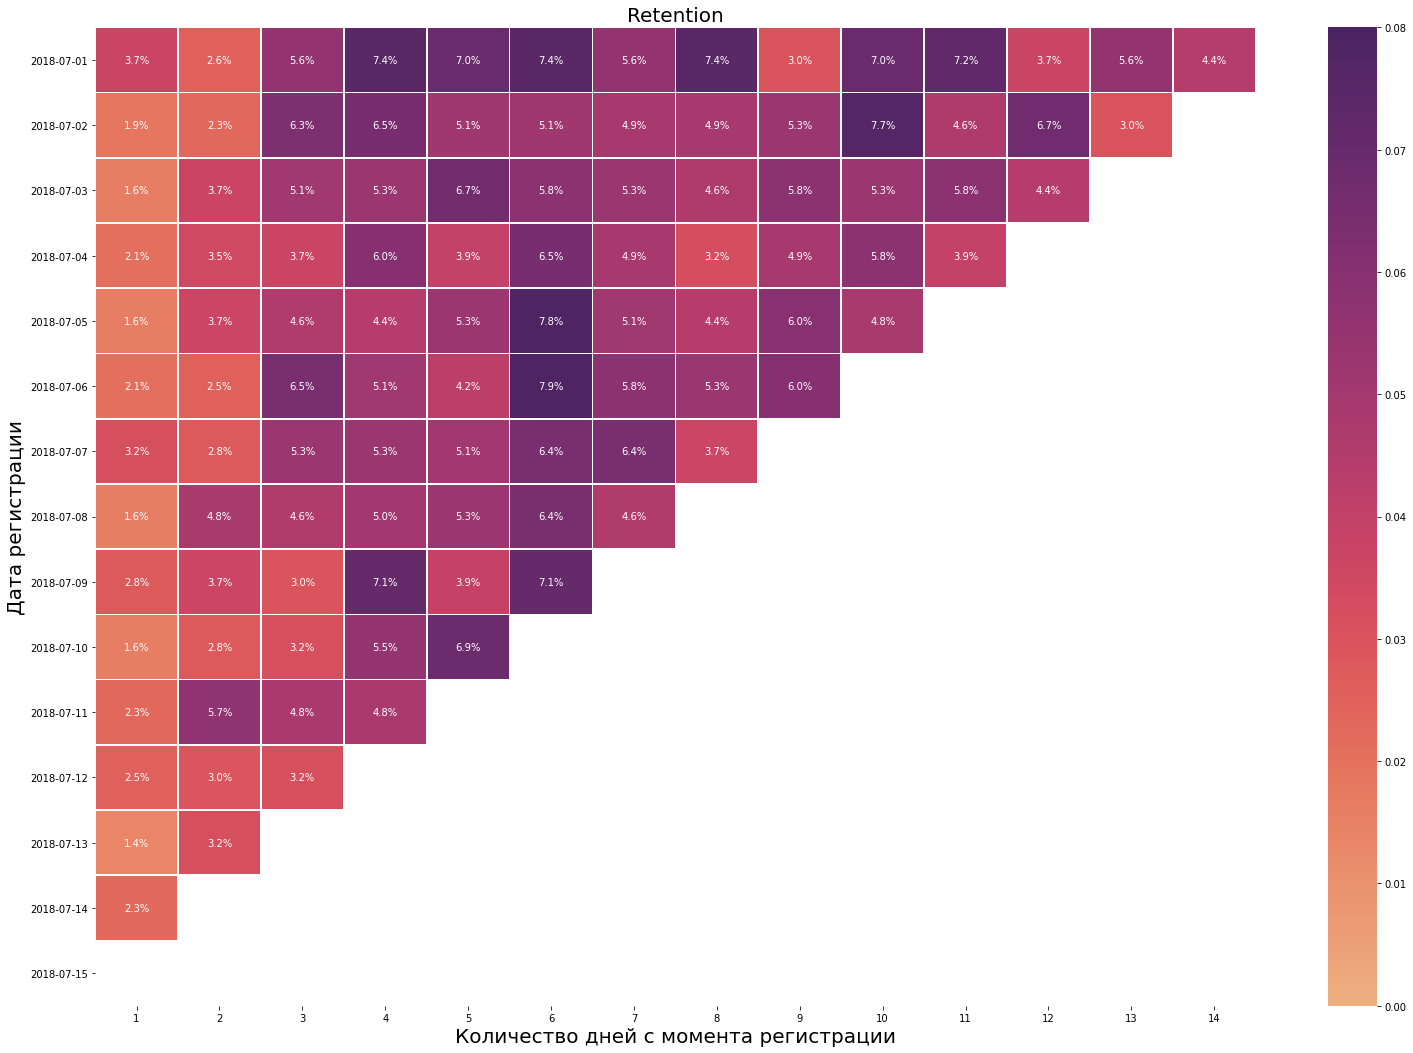

In [16]:
retention_heatmap(problem_reg_df, problem_auth_df, '2018-07-01', '2018-07-15')

## Задание №2

### Условие задания

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### Разведка данных

Перед тем, как приступить к заданию необходимо разведать имеющиеся данные по A/B тесту (количество строк и серий, наличие пустых данных и дубликатов и т.д.).

In [17]:
# Считываем csv файл с информацие об A/B тесту и сохраняем в переменной 'AB_test_df'
AB_test_df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [18]:
#Смотрим шапку датафрейма (надо понять в каком виде записаны данные)
AB_test_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [19]:
# Смотрим колличетсво строк, типы данных в сериях и количество пустых значений
AB_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [20]:
# Проверяем количество дубликатов в полученных данных (иногда выгружают данные неправильно)
print(f'Количество дубликатов в данных: {AB_test_df.duplicated().sum()}')

Количество дубликатов в данных: 0


Для дальнейшего выполнения задания нам понадобится разбить на отдельные датафреймы: контрольной и тестовой группы.

Можно заранее это сделать. Но необходимо определить контрольную и тестовую группу в датафрейме.

In [21]:
# Считаем количество пользователей в группах. Там где будет 202103 - контрольная группа, а 202667 - тестовая
AB_test_df.groupby('testgroup',
                   as_index=False)\
          .agg({'user_id':'nunique'})\
          .rename(columns={'user_id': 'users'})

,testgroup,users
0,a,202103
1,b,202667


Для удобства я бы заменил 'а' на 'control', а 'b' на 'test'. Так будет приятнее работать с данными.

In [22]:
# Заменяем значения через replace и сохраняем изменения
AB_test_df['testgroup'] = AB_test_df['testgroup'].replace('a', 'control')
AB_test_df['testgroup'] = AB_test_df['testgroup'].replace('b', 'test')

In [23]:
# На всякий посмотрим прошла ли замена всех значений
AB_test_df.testgroup.unique()

array(['test', 'control'], dtype=object)

In [24]:
# Также можно проверить соответствует ли условию задания количество платящих игроков в группах
# В контрольной их должно быть - 1928, в тестовой - 1805
AB_test_df.loc[AB_test_df['revenue'] > 0]\
          .groupby('testgroup')\
          .user_id.count()

testgroup
control    1928
test       1805
Name: user_id, dtype: int64

Сразу разделем на два отдельных датафрейма: контрольной группы и тестовой группы.

In [25]:
# Разделяем по значениям в серии 'testgroup' и сохраняем в новые переменные
control_df = AB_test_df.loc[AB_test_df['testgroup'] == 'control']
test_df = AB_test_df.loc[AB_test_df['testgroup'] == 'test']

In [26]:
# Проверяем по колличеству строк, что разделили правильно (на всякий случай)
print(control_df.shape)
print(test_df.shape)

(202103, 3)
(202667, 3)


### Анализ акционных наборов

Нам нужно понять какой лучше акционный набор: в контрольной или тестовой группе.
Для этого необходимо правильно подобрать метрики, по которым можно сравнить акционные наборы.

В нашем случае подходят следующие:

1) Конверсия (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей (в нашем случае совершили покупку);
    
2) ARPU (Average revenue per user) - cредний доход с привлечённого пользователя;
    
3) ARPPU (Average revenue per paying user) - cредний доход на платящего пользователя, то есть клиента (cостоит из того, насколько часто пользователь покупает, и насколько большой средний чек покупки).
    
Все 3 показателя можно считать основными, так как взаимосвязаны. Все они отражает предпочтительность того или иного набора.

Сначала посмотрим распределение выручки в каждой из групп.

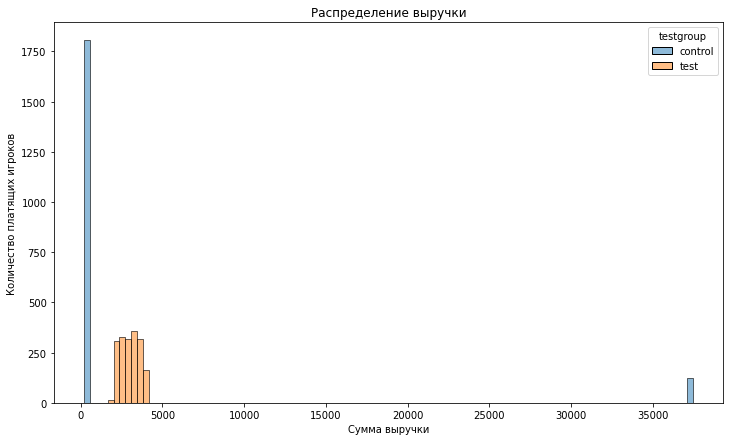

In [27]:
plt.figure(figsize=(12, 7))
df_pay = sns.histplot(data=AB_test_df.loc[AB_test_df['revenue'] > 0], x='revenue', hue='testgroup', kde=False)
df_pay.set(xlabel='Сумма выручки',
           ylabel='Количество платящих игроков',
           title='Распределение выручки')
plt.show()

Очень настораживающее распределение. Видим что по выручке контрольная и тестовая группы не пересекаются.

В контрольной группе видны огромный разброс в данных. Большая часть пользователей смещенна к 0 сумме выручки, однако небольшая часть пользователей ушла за 35000. Возможно это выбросы. Однако сказать уверенно не можем.

В тестовой группе наблюдаем равномерность в распределении выручки.

Стоит посмотреть какое количество пользователей в контрольной группе составляют предполагаемый выброс, а также долю выручки от этих пользователей от общей. Это поможет нам сделать выводы о предполагаемых выбросах.

In [28]:
# Используя ранее подготовленные датафреймы, сформируем два других по платящим пользователям в разных группах
control_pay_df = control_df.loc[control_df['revenue'] > 0]
test_pay_df = test_df.loc[test_df['revenue'] > 0]

In [29]:
# Оставляем данные только по пользователям, у которых 'revenue' > 30000 в контрольной группе
revenue_more_30000 = control_pay_df.loc[control_pay_df['revenue'] > 30000]

# Cчитаем колличество этих пользователей
revenue_more_30000_size = revenue_more_30000['revenue'].size

# Выводим результат
print(f'Количество игроков, у которых revenue > 30000: {revenue_more_30000_size}')

Количество игроков, у которых revenue > 30000: 123


In [30]:
# Считаем долю выручки этих 123 пользователей от общей выручки
revenue_more_30000_percent = revenue_more_30000['revenue'].sum() / control_pay_df['revenue'].sum()
revenue_more_30000_percent = round((revenue_more_30000_percent * 100))

# Выводим результат
print(f'Процент от общей выручки, который дают 123 игрока: {revenue_more_30000_percent}%')

# Удаляем ненужные переменные
del revenue_more_30000, revenue_more_30000_size, revenue_more_30000_percent

Процент от общей выручки, который дают 123 игрока: 89%


После анализа предполагаемых выбросов в контрольной группе можно сказать следующее:
    
1) Выручка данной подгруппы составляет 89% от общей, что очень много;
    
2) Убирать эти данные для дальнейшего анализа - нельзя;
    
3) Можно предположить, что это не выбросы, а специфика показа акционных наборов (возможно просто изначально они по задумке показывались группам игроков с разным показателем выручки).

Также рассмотрим минимальные, максимальные, средние и медианные значения по выручке в обеих группах.
Для удобства создадим 2 новых датафрейма.

In [31]:
# Смотрим показатели по платящим в контрольной группе
control_pay_df.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [32]:
# Смотрим показатели по платящим в тестовой группе
test_pay_df.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Детализированное рассмотрение показателей по выручке в обеих группах еще больше подтверждает сделанные ранее наблюдения. Медиана по выручке в тестовой группе почти в 10 раз больше чем в контрольной. Разница между минимальным и максимальным значениям очень сильно отличается: в контрольной максимальное значение больше в 187 раз, в тестовой больше в 2 раза.

Уже на данном этапе напрашивается повторный A/B тест, но с учетом корректного сплитования (показа акционных наборов).

Однако необходимо завершить анализ и только потом делать итоговые выводы.

#### Расчет показателей (CR, ARPU, ARPPU)

Расчитаем CR

In [33]:
# Считаем CR для каждой группы
control_CR = round((control_pay_df['user_id'].nunique() * 100) / control_df['user_id'].nunique(), 2)
test_CR = round((test_pay_df['user_id'].nunique() * 100) / test_df['user_id'].nunique(), 2)

# Выводим показатели
print(f'CR в контрольной группе: {control_CR}%')
print(f'CR в тестовой группе: {test_CR}%')

CR в контрольной группе: 0.95%
CR в тестовой группе: 0.89%


Расчитаем ARPPU

In [34]:
# Считаем ARPPU для каждой группы
control_ARPPU = round(control_pay_df.revenue.sum() / control_pay_df.user_id.nunique(), 2)
test_ARPPU = round(test_pay_df.revenue.sum() / test_pay_df.user_id.nunique(), 2)

# Выводим показатели
print(f'ARPPU в контрольной группе: {control_ARPPU}')
print(f'ARPPU в тестовой группе: {test_ARPPU}')

ARPPU в контрольной группе: 2664.0
ARPPU в тестовой группе: 3003.66


Расчитаем ARPU

In [35]:
# Считаем ARPU для каждой группы
control_ARPU = round(control_df.revenue.sum() / control_df.user_id.nunique(), 2)
test_ARPU = round(test_df.revenue.sum() / test_df.user_id.nunique(), 2)

# Выводим показатели
print(f'ARPU в контрольной группе: {control_ARPU}')
print(f'ARPU в тестовой группе: {test_ARPU}')

ARPU в контрольной группе: 25.41
ARPU в тестовой группе: 26.75


После расчета показателей мы видим, что CR больше в контрольной группе, но ARPU и ARPPU больше в тестовой. Делать выводы все еще рано. Нужно понять статистическую значимость данных показателей. 

#### Проведение статистических тестов (для CR, ARPU, ARPPU)

Начнем с CR.

Данный показатель можно проверить через Хи-квадрат. Так как в расчете СR мы смотрим соотношенией покупающих игроков (пользователей) к общему числу, то тогда мы имеем дело с категориальными данными. Собственно на этом и строится статистический тест (проверяет гипотезы о распределении категориальных данных).

In [36]:
# Добавим новую серию (признак) в AB_test_df для разделения пользователей на покупающих и непокупающих
AB_test_df['paygroup'] = AB_test_df['revenue'].apply(lambda x: '1' if x > 0 else '0')

# Теперь создадим таблицу сопряженности
CR_X2 = AB_test_df.groupby(['testgroup', 'paygroup'], as_index=False)\
                  .agg({'user_id':'nunique'})\
                  .pivot(index = 'testgroup', columns = 'paygroup', values = 'user_id')

# Выводим и проверяем таблицу сопряженности
CR_X2

paygroup,0,1
testgroup,,
control,200175,1928
test,200862,1805


Формируем H0 и H1:

1) H0: по показателю CR между контрольной и тестовой группами нет различий;
     
2) H1: по показателю CR между контрольной и тестовой группами есть различия.

In [37]:
# Проводим сам тест и сохраняем p-value в переменную CR_p_value
CR_p_value = scipy.stats.chi2_contingency(CR_X2)[1]

# Выводим с помощью цикла результаты по итогам теста
if CR_p_value < 0.05:
    print(f'P-value {CR_p_value} < 0.05 - отклоняем HO.')
else:
    print(f'P-value {CR_p_value} > 0.05 - не отклоняем HO.')

P-value 0.03647561892312613 < 0.05 - отклоняем HO.


Тестом мы подведили, что различия по показателю CR значимы.

Теперь перейдем к показателям ARPU и ARPPU.

В основе двух этих показателей лежит средние значения, поэтому стоит рассматреть t-test для выявления статистической значимости. Одако, у t-test есть ряд требований:
     
1) Нормальность распределения выборок (можно игнорировать, если число наблюдений > 30);
     
2) Должна соблюдаться гомоскедантичность для обеих групп (равенство дисперсий).
     
Первое требование у нас выполняется за счет огромного количества наблюдей, поэтому проверка на нормальность распределения через тест Шапиро-Уилка не имеет смысла.

Второе требование нужно будет проверять для каждого показателя отдельно, через тест Левена. Однака, если будет выявлено неравенство дисперсий - это не будет служить отказом от t-test'а. Нам просто придется использовать t-test с критерием Уэлча (как раз таки этот критерий учитывает неравенство дисперсий).

Начнем с ARPU.

In [38]:
# Проверяем на равенство дисперсий через тест Левена и сохраняем в переменную ARPU_Leven_p_value
ARPU_Leven_p_value = scipy.stats.levene(control_df.revenue, test_df.revenue)[1]

# Выводим с помощью цикла результаты по итогам теста
if ARPU_Leven_p_value < 0.05:
    print(f'P-value {ARPU_Leven_p_value} < 0.05 - дисперсии не равны')
else:
    print(f'P-value {ARPU_Leven_p_value} > 0.05 - дисперсии равны')

P-value 0.5324948591043842 > 0.05 - дисперсии равны


Так как дисперсии равны, то используем t-test без критерия Уэлча.

Формируем H0 и H1:

1) H0: по показателю ARPU между контрольной и тестовой группами нет различий;
     
2) H1: по показателю ARPU между контрольной и тестовой группами есть различия.

In [39]:
# Проводим сам тест и сохраняем p-value в переменную ARPU_p_value
ARPU_p_value = scipy.stats.ttest_ind(control_df.revenue, test_df.revenue)[1]

# Выводим с помощью цикла результаты по итогам теста
if ARPU_p_value < 0.05:
    print(f'P-value {ARPU_p_value} < 0.05 - отклоняем HO.')
else:
    print(f'P-value {ARPU_p_value} > 0.05 - не отклоняем HO.')

P-value 0.532494858971837 > 0.05 - не отклоняем HO.


Тест выявил отсутствие статистически значимых различий между группами по показателю ARPU.

Перейдем к последнему показателю - ARPPU.

In [40]:
# Проверяем на равенство дисперсий через тест Левена и сохраняем в переменную ARPPU_Leven_p_value
ARPPU_Leven_p_value = scipy.stats.levene(control_pay_df.revenue, test_pay_df.revenue)[1]

# Выводим с помощью цикла результаты по итогам теста
if ARPPU_Leven_p_value < 0.05:
    print(f'P-value {ARPPU_Leven_p_value} < 0.05 - дисперсии не равны')
else:
    print(f'P-value {ARPPU_Leven_p_value} > 0.05 - дисперсии равны')

P-value 3.779689868667878e-19 < 0.05 - дисперсии не равны


В этом случае дисперсии неравны. Использовать будем t-test с критерием Уэлча.

Формируем H0 и H1:

1) H0: по показателю ARPPU между контрольной и тестовой группами нет различий;
     
2) H1: по показателю ARPPU между контрольной и тестовой группами есть различия.

In [41]:
# Проводим сам тест и сохраняем p-value в переменную ARPPU_p_value
ARPPU_p_value = scipy.stats.ttest_ind(control_pay_df.revenue, test_pay_df.revenue, equal_var=False)[1]

# Выводим с помощью цикла результаты по итогам теста
if ARPPU_p_value < 0.05:
    print(f'P-value {ARPPU_p_value} < 0.05 - отклоняем HO.')
else:
    print(f'P-value {ARPPU_p_value} > 0.05 - не отклоняем HO.')

P-value 0.10020780398916015 > 0.05 - не отклоняем HO.


Тест выявил отсутствие статистически значимых различий между группами по показателю ARPPU.

### Выводы по акционным наборам и проведению эксперимента

По итогу всех тестов только показатель CR статистически значим, что склоняет нас сказать, что в контрольной группе акционный набор лучше.

Однако, правильнее было бы провести повторный A/B тест! Притом огромное внимание стоило бы уделить сплитованию пользоватлей на группы. Сам факт того, что доходность контрольной и тестовой групп не пересекаеся указывает нам на неправильное проведение эксперимента. Другой дополнительной информации по проведению эксперимента у нас тоже нет.

Возможно, это специфика предложения акционных наборов. Есть вероятность того, что контрольной группе показывали разные акционные наборы, но с учетом покупательской способности игроков (исторические данные). А в тестовой показывали акционные наборы в пределах определенного диапозона. Но это все догадки и не имеют оснований под собой.

## Задание №3

## Условия задач проекта

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Метрики для оценки события

Сначала подумаем, от чего зависит успешность проводимого ивента для компании?

Тут можно выделить 2 пункта:

1) Заинтересованность игроков;
    
2) Монетизация продукта (игры).
    
Следовательно, нам нужно подобрать такие метрики, которые бы отражали два этих пункта.

Метрики отслеживающие заинтересованность:

1) Доля участвующих игрокв от общего числа (помогает отследить как сильно событие заинтересовало аудиторию);
    
2) Дневная аудитория (DAU) — количество уникальных игроков, участвовавших в ивенте в рамках дня;
    
3) Недельная аудитория (WAU) - количество уникальных игроков, участвовавших в ивенте в рамках недели;
    
4) Удержание (Retention) - процент игроков, вернувшихся в игру после начала ивента;
    
5) Доля завершивших ивент игроков от числа участников (одновременно отслеживает насколько привлек ивент игроков и отражает сложность ивента);
    

Метрики отслеживающие монетизацию:

1) Конверсия в покупку (CR) - процент игроков, которые сделали покупку связанную с ивентом (артефакт, расходуемые предметы и т.д. в рамках ивента);
    
2) Средний доход на игрока (ARPU);
    
3) Средний доход на платящего игрока (ARPPU).

### Метрики для оценки усложненного события

В другом ивенте у нас меняются условия - усложняются механики игры (откат уровней из-за неудачной попытки).

На что влияет сложность:

1) На прогресс игроков (уже не все смогут пройти полностью ивент за месяц);
    
2) На удержание игроков (некоторые игроки могут вскорости после начала ивента покинуть его, а позже и саму игру);
    
3) На оценку продукта (все же мобильные игры в основной массе нацелены на более широкую и казуальную аудиторию).
    
Указанные выше пункты являются скорее зонами риска. С одной стороны - продукт может стать интереснее, с другой - при переусердствовании может привести к снижению заинтересованости игрой и снижению монетизации.

Исходя из этого нужно будет добавить еще метрики, связанные с этими зонами риска:
    
1) Доля откатов от общего числа попыток (поможет понять насколько переусложнили ивент);
    
2) Колличество неуспешных попыток разбитых по уровням (так мы можем отследить и откоректировать сложность конкретного этапа игры);
    
3) Отток (Churn Rate) - процент ингроков покинувших игру после начала ивента;
    
4) Оценка/отзыв игроков (поможет более детально отследить как проблемы игры, так и успешные решения разработчиков).